In [ ]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "IHVPMRMj2O6SiK5pzbDbg9jUp"

# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity > /dev/null 2>&1

In [ ]:
# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please insert your Comet API Key"

In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

Found 817 songs in text


In [ ]:
# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
### Define numerical representation of text ###

In [ ]:
# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u: i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)
### Vectorize the songs string ###

In [ ]:
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

# def vectorize_string(string):
  # TODO

vectorized_songs = vectorize_string(songs_joined)

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0] - 1
    # randomly choose the starting indices for the examples in the training batch
    idx = np.random.choice(n - seq_length, batch_size)

    '''TODO: construct a list of input sequences for the training batch'''
    input_batch = [vectorized_songs[i: i + seq_length] for i in idx]

    '''TODO: construct a list of output sequences for the training batch'''
    output_batch = [vectorized_songs[i + 1: i + seq_length + 1] for i in idx]

    # Convert the input and output batches to tensors
    x_batch = torch.tensor(input_batch, dtype=torch.long)
    y_batch = torch.tensor(output_batch, dtype=torch.long)

    return x_batch, y_batch

In [ ]:
# Perform some simple tests to make sure your batch function is working properly! 测试完删
test_args = (vectorized_songs, 10, 2)
x_batch, y_batch = get_batch(*test_args)
assert x_batch.shape == (2, 10), "x_batch shape is incorrect"
assert y_batch.shape == (2, 10), "y_batch shape is incorrect"
print("Batch function works correctly!")

Batch function works correctly!


In [ ]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Linear layers to define the RNN model using nn.Module'''
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # Define each of the network layers
        # Layer 1: Embedding layer to transform indices into dense vectors
        #   of a fixed embedding size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Layer 2: LSTM with hidden_size `hidden_size`. note: number of layers defaults to 1.
        # TODO: Use the nn.LSTM() module from pytorch.
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        # self.lstm = nn.LSTM('''TODO''')

        # Layer 3: Linear (fully-connected) layer that transforms the LSTM output
        #   into the vocabulary size.
        # TODO: Add the Linear layer.
        self.fc = nn.Linear(hidden_size, vocab_size)
        # self.fc = nn.Linear('''TODO''')

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state with zeros
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))

    def forward(self, x, state=None, return_state=False):
        x = self.embedding(x)

        if state is None:
            state = self.init_hidden(x.size(0), x.device)
        out, state = self.lstm(x, state)

        out = self.fc(out)
        return out if not return_state else (out, state)

In [ ]:
# Instantiate the model! Build a simple model with default hyperparameters. You
#     will get the chance to change these later.
vocab_size = len(vocab)
embedding_dim = 256
hidden_size = 1024
batch_size = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(vocab_size, embedding_dim, hidden_size).to(device)

In [ ]:
# print out a summary of the model
print(model)
# Test the model with some sample data
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
x = x.to(device)
y = y.to(device)

pred = model(x)

LSTMModel(
  (embedding): Embedding(83, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=83, bias=True)
)


In [ ]:
### Defining the loss function定义损失函数 ###

# '''TODO: define the compute_loss function to compute and return the loss between
#     the true labels and predictions (logits). '''
cross_entropy = nn.CrossEntropyLoss() # instantiates the function
def compute_loss(labels, logits):
    """
    Inputs:
      labels: (batch_size, sequence_length)
      logits: (batch_size, sequence_length, vocab_size)

    Output:
      loss: scalar cross entropy loss over the batch and sequence length
    """

    # Batch the labels so that the shape of the labels should be (B * L,)
    batched_labels = labels.view(-1)

    ''' TODO: Batch the logits so that the shape of the logits should be (B * L, V) '''
    batched_logits = logits.view(-1, logits.size(-1))
    # batched_logits = """ TODO """ # TODO

    '''TODO: Compute the cross-entropy loss using the batched  next characters and predictions'''
    loss = cross_entropy(batched_logits, batched_labels)
    # loss = """ TODO """ # TODO
    return loss

In [ ]:
### compute the loss on the predictions from the untrained model from earlier. ###
y.shape  # (batch_size, sequence_length)
pred.shape  # (batch_size, sequence_length, vocab_size)

'''TODO: compute the loss using the true next characters from the example batch
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)
# example_batch_loss = compute_loss('''TODO''', '''TODO''') # TODO

print(f"Prediction shape: {pred.shape} # (batch_size, sequence_length, vocab_size)")
print(f"scalar_loss:      {example_batch_loss.mean().item()}")
### Hyperparameter setting and optimization ###

vocab_size = len(vocab)

Prediction shape: torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)
scalar_loss:      4.41683292388916


In [ ]:
# Model parameters:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 50,  # Experiment between 50 and 500
  learning_rate = 2e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  hidden_size = 2048,  # Experiment between 1 and 2048
)

In [ ]:
# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
### Create a Comet experiment to track our training run ###

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

In [ ]:
### Define optimizer and training operation ###

'''TODO: instantiate a new LSTMModel model for training using the hyperparameters
    created above.'''
model = LSTMModel(vocab_size, params["embedding_dim"], params["hidden_size"])
# model = LSTMModel('''TODO: arguments''')

# Move the model to the GPU
model.to(device)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the PyTorch website for a list of supported optimizers.
  https://pytorch.org/docs/stable/optim.html
  Try using the Adam optimizer to start.'''
optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])

In [ ]:
def train_step(x, y):
  # Set the model's mode to train
  model.train()

  # Zero gradients for every step
  optimizer.zero_grad()

  # Forward pass
  '''TODO: feed the current input into the model and generate predictions'''
  y_hat = model(x) # TODO
  # y_hat = model('''TODO''')

  # Compute the loss
  '''TODO: compute the loss!'''
  loss = compute_loss(y, y_hat) # TODO
  # loss = compute_loss('''TODO''', '''TODO''')

  # Backward pass
  '''TODO: complete the gradient computation and update step.
    Remember that in PyTorch there are two steps to the training loop:
    1. Backpropagate the loss
    2. Update the model parameters using the optimizer
  '''
  loss.backward() # TODO
  optimizer.step() # TODO

  return loss

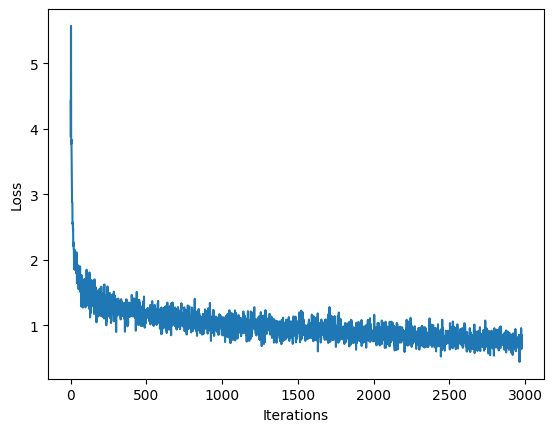

100%|██████████| 3000/3000 [03:01<00:00, 16.51it/s]
COMET INFO: Uploading 246 metrics, params and output messages


True

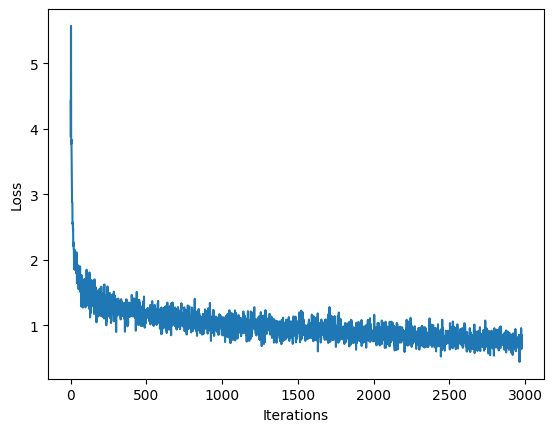

In [ ]:
##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])

    # Convert numpy arrays to PyTorch tensors
    x_batch = torch.tensor(x_batch, dtype=torch.long).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)

    # Take a train step
    loss = train_step(x_batch, y_batch)

    # Log the loss to the Comet interface
    experiment.log_metric("loss", loss.item(), step=iter)

    # Update the progress bar and visualize within notebook
    history.append(loss.item())
    plotter.plot(history)

    # Save model checkpoint
    if iter % 100 == 0:
        torch.save(model.state_dict(), checkpoint_prefix)

# Save the final trained model
torch.save(model.state_dict(), checkpoint_prefix)
experiment.flush()

In [ ]:
### Prediction of a generated song生成歌曲 ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_idx = [char2idx[s] for s in start_string] # TODO
  # input_idx = ['''TODO''']
  input_idx = torch.tensor([input_idx], dtype=torch.long).to(device)

  # Initialize the hidden state
  state = model.init_hidden(input_idx.size(0), device)

  # Empty string to store our results
  text_generated = []
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
    '''TODO: evaluate the inputs and generate the next character predictions'''
    predictions, state = model(input_idx, state, return_state=True)
    # predictions, hidden_state = model('''TODO''', '''TODO''', return_state=True)

    # Remove the batch dimension
    predictions = predictions.squeeze(0)

    '''TODO: use a multinomial distribution to sample over the probabilities'''
    input_idx = torch.multinomial(torch.softmax(predictions, dim=-1), num_samples=1)
    # input_idx = torch.multinomial('''TODO''', dim=-1), num_samples=1)

    '''TODO: add the predicted character to the generated text!'''
    # Hint: consider what format the prediction is in vs. the output
    text_generated.append(idx2char[input_idx].item()) # TODO
    # text_generated.append('''TODO''')


  return (start_string + ''.join(text_generated))
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO

100%|██████████| 1000/1000 [00:00<00:00, 1624.34it/s]


In [ ]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    experiment.log_asset(wav_file_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# when done, end the comet experiment
experiment.end()

COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : azure_cloudberry_6273
COMET INFO:     url                   : https://www.comet.com/slinchen-1/6s191-lab1-part2/c471e42623ba47118107bef79662bc42
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3300] : (0.4434005618095398, 5.569828987121582)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1Jb6HP7X7rtxRw_XdLJlf_eA1u2jxS4bh
COMET INFO:   Parameters:
COMET INFO:     batch_size              : 8
COMET INFO:     embedding_dim           : 256
COMET INFO:     hidden_size  